# [HYPOTHESIS]  Certain intermediate and sender errors will always cause GP2GP transfer failure

## Hypothesis
We believe that there are specific intermediate or sender error codes that result in failed GP2GP transfers, and therefore should automatically be interpreted as failed, and the failure can be attributed to that intermediate or sender error.

We will know this to be true when we can see in the data that certain intermediate or sender errors never result in integrations, and always result in failures.

We did the following:
- Using 6 months of data -  from September 2020 to February 2021 (using transfers dataset) - looking solely at transfers which resulted in integration or failure (i.e. we exclude transfers that are pending or pending with error, since we do not know the eventual outcome of these transfers):
- identify if there are any error codes (sender, or intermediate) that we never recover from
- for each error code, breakdown the transfers by the resulting outcome (failure or integrated)
- present the probability of success per error code and rank in order of most likely to succeed

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import paths
import data
error_code_lookup_file = pd.read_csv(data.gp2gp_response_codes.path)

In [3]:
transfer_file_location = "s3://prm-gp2gp-data-sandbox-dev/transfers-sample-3/"
transfer_files = [
    "9-2020-transfers.parquet",
    "10-2020-transfers.parquet",
    "11-2020-transfers.parquet",
    "12-2020-transfers.parquet",
    "1-2021-transfers.parquet",
    "2-2021-transfers.parquet",
]
transfer_input_files = [transfer_file_location + f for f in transfer_files]
transfers = pd.concat((
    pd.read_parquet(f)
    for f in transfer_input_files
))

In [4]:
def group_by_errors(error_field, df):
    transfers_with_errors = df.groupby([error_field, 'status']).count()[['conversation_id']].unstack().fillna(0)
    transfers_with_errors.columns = transfers_with_errors.columns.get_level_values(1)
    transfers_with_errors["total_count"] = transfers_with_errors[["PENDING_WITH_ERROR","FAILED","INTEGRATED"]].sum(axis=1)
    transfers_with_errors= transfers_with_errors.astype(int)
    return transfers_with_errors.sort_values(by=['INTEGRATED','PENDING_WITH_ERROR'], ascending=[False,False])

In [5]:
def generate_percentages(df):
    transfers_with_percentage = df.iloc[:, 0:3].apply(lambda x: x / df.iloc[:, 3] * 100)
    transfers_with_percentage = transfers_with_percentage.sort_values(by=['INTEGRATED', 'PENDING_WITH_ERROR'], ascending=[False,False])
    transfers_with_percentage = transfers_with_percentage.add_suffix(' (%)')
    return transfers_with_percentage.round(2)

## Transfers with sender errors

In [6]:
transfers_with_sender_errors = group_by_errors('sender_error_code', transfers)
transfers_with_sender_errors

status,PENDING_WITH_ERROR,INTEGRATED,FAILED,total_count
sender_error_code,,,,
20.0,2844,1110,1036,4990
19.0,311,74,39,424
14.0,10195,3,0,10198
23.0,419,3,2,424
30.0,7393,0,0,7393
10.0,3523,0,0,3523
6.0,898,0,0,898
7.0,727,0,0,727
24.0,134,0,1,135


In [7]:
transfers

,conversation_id,sla_duration,requesting_practice_asid,sending_practice_asid,sender_error_code,final_error_code,intermediate_error_codes,status,date_requested,date_completed
0,D488E760-0324-11EB-A3B5-4D1FA0724B18,517223.0,200000017777,200000014940,NaN,NaN,[],INTEGRATED,2020-09-30 13:57:08.865,2020-10-06 13:38:20.767
1,5CD78565-D2FD-4EB3-BD85-417AB3A9FBC9,8743.0,769795397017,483630377016,NaN,NaN,[],INTEGRATED,2020-09-30 14:00:51.291,2020-09-30 16:26:45.241
2,B817DE2D-F485-46B7-BC53-31F2E2CB1CD4,3824.0,900801796013,087679877040,NaN,NaN,[],INTEGRATED,2020-09-30 14:00:41.916,2020-09-30 15:04:45.207
3,60F55950-0324-11EB-B9BD-4DAF4F9D3435,951.0,681852386017,204892648013,NaN,NaN,[],INTEGRATED,2020-09-30 13:53:55.623,2020-09-30 14:16:10.610
4,529B83BC-7C1F-468B-913C-5D5ED5FF9A8E,413681.0,200000000693,675147025042,NaN,15.0,[],INTEGRATED,2020-09-30 13:57:47.502,2020-10-05 08:53:41.024
...,...,...,...,...,...,...,...,...,...,...
234552,75173BD9-37A6-4E15-856E-F173317D01E6,NaN,994133653042,950140416013,NaN,NaN,[],PENDING,2021-02-01 10:38:41.327,NaT
234553,A2EB628E-8074-4943-B6E9-E59F6A94C792,615.0,345196753049,181445352014,NaN,NaN,[],INTEGRATED,2021-02-01 09:14:17.209,2021-02-01 09:24:44.125
234554,3A0FD1DF-7A30-4B7C-B845-1A353DA58F0B,NaN,200000001410,227784357013,NaN,NaN,[],PENDING,2021-02-01 08:59:25.769,NaT
234555,AEE4F29B-9A97-4BDF-9E40-E96D171034DE,4706.0,200000000572,272774518018,NaN,NaN,[],INTEGRATED,2021-02-01 09:04:53.466,2021-02-01 10:23:29.529


In [8]:
transfers_with_sender_errors_percentage = generate_percentages(transfers_with_sender_errors)
transfers_with_sender_errors_percentage

status,PENDING_WITH_ERROR (%),INTEGRATED (%),FAILED (%)
sender_error_code,,,
20.0,56.99,22.24,20.76
19.0,73.35,17.45,9.20
23.0,98.82,0.71,0.47
14.0,99.97,0.03,0.00
30.0,100.00,0.00,0.00
10.0,100.00,0.00,0.00
6.0,100.00,0.00,0.00
7.0,100.00,0.00,0.00
99.0,100.00,0.00,0.00


## Conclusion

The table above shows that it is possible to recover from the following errors recorded by the sender and that transfers with these errors may be eventually integrated:
- error code **20** (22.24% integrated) - *Spine system  responded with an error*
- error code **19** (17.45% integrated) - *Sender check indicates that Requester is not the patient’s current healthcare provider*
- error code **23** (0.71% integrated) - *Message not sent because sending practice is not Large Message compliant*
- error code **14** (0.03% integrated) - *Message not sent because requestingpractice is not Large Message compliant*

## Transfers with intermediate errors

In [9]:
has_intermediate_errors = transfers["intermediate_error_codes"].apply(len) > 0
transfers_with_intermediate_errors_exploded = transfers[has_intermediate_errors].explode("intermediate_error_codes")
transfers_with_unique_intermediate_errors = transfers_with_intermediate_errors_exploded.drop_duplicates(subset=["conversation_id", "intermediate_error_codes"])

transfers_with_intermediate_errors = group_by_errors("intermediate_error_codes", transfers_with_unique_intermediate_errors)
transfers_with_intermediate_errors

status,FAILED,INTEGRATED,PENDING_WITH_ERROR,total_count
intermediate_error_codes,,,,
29,1212,390,44,1646
12,49,52,8,109
30,4,10,4,18
31,17,2,0,19
25,2,1,1,4
11,19,1,0,20
15,5,0,30,35
99,5,0,5,10
17,4,0,0,4


### Caveat

For transfers with multiple different error codes, each error code will be counted as a new transfer.

In [10]:
transfers_with_intermediate_errors_percentage = generate_percentages(transfers_with_intermediate_errors)
transfers_with_intermediate_errors_percentage

status,FAILED (%),INTEGRATED (%),PENDING_WITH_ERROR (%)
intermediate_error_codes,,,
30,22.22,55.56,22.22
12,44.95,47.71,7.34
25,50.00,25.00,25.00
29,73.63,23.69,2.67
31,89.47,10.53,0.00
11,95.00,5.00,0.00
15,14.29,0.00,85.71
99,50.00,0.00,50.00
17,100.00,0.00,0.00


## Conclusion

The table above shows that it is possible to recover from the following intermediate errors and that transfers with these errors may be eventually integrated:
- error code **30** (55.56% integrated) - *Large Message general failure*
- error code **12** (47.71% integrated) - *Duplicate EHR Extract received*
- error code **25** (25.00% integrated) - *Large messages rejected due to timeout duration reached of overall transfer*
- error code **29** (23.69% integrated) - *Large Message Re-assembly failure*
- error code **31** (10.53% integrated) - *The overall EHR Extract has been rejected because one or more attachments via Large Messageswere not received*
- error code **11** (5.00% integrated) - *Failed to successfully integrate EHR Extract*

## Merging sender and intermediate errors

In [11]:
transfers_with_sender_and_intermediate_errors = pd.concat([transfers_with_sender_errors, transfers_with_intermediate_errors])
transfers_with_sender_and_intermediate_errors = transfers_with_sender_and_intermediate_errors.groupby(transfers_with_sender_and_intermediate_errors.index).sum()
transfers_with_sender_and_intermediate_errors = transfers_with_sender_and_intermediate_errors.sort_values(by=['INTEGRATED', 'total_count'], ascending=[False,False])
transfers_with_sender_and_intermediate_errors

,PENDING_WITH_ERROR,INTEGRATED,FAILED,total_count
20.0,2844,1110,1036,4990
29.0,44,390,1212,1646
19.0,311,74,39,424
12.0,8,52,49,109
30.0,7397,10,4,7411
14.0,10195,3,0,10198
23.0,419,3,2,424
31.0,0,2,17,19
11.0,0,1,19,20
25.0,1,1,2,4


In [12]:
transfers_with_sender_and_intermediate_errors_percentage = generate_percentages(transfers_with_sender_and_intermediate_errors)
transfers_with_sender_and_intermediate_errors_percentage

,PENDING_WITH_ERROR (%),INTEGRATED (%),FAILED (%)
12.0,7.34,47.71,44.95
25.0,25.00,25.00,50.00
29.0,2.67,23.69,73.63
20.0,56.99,22.24,20.76
19.0,73.35,17.45,9.20
31.0,0.00,10.53,89.47
11.0,0.00,5.00,95.00
23.0,98.82,0.71,0.47
30.0,99.81,0.13,0.05
14.0,99.97,0.03,0.00


In [13]:
transfers_with_sender_and_intermediate_errors_total = transfers_with_sender_and_intermediate_errors.merge(transfers_with_sender_and_intermediate_errors_percentage, left_index=True, right_index=True, how="outer")
transfers_with_sender_and_intermediate_errors_total = transfers_with_sender_and_intermediate_errors_total.sort_values(by=["INTEGRATED (%)", "total_count"], ascending=[False,False])
transfers_with_sender_and_intermediate_errors_total

,PENDING_WITH_ERROR,INTEGRATED,FAILED,total_count,PENDING_WITH_ERROR (%),INTEGRATED (%),FAILED (%)
12.0,8,52,49,109,7.34,47.71,44.95
25.0,1,1,2,4,25.00,25.00,50.00
29.0,44,390,1212,1646,2.67,23.69,73.63
20.0,2844,1110,1036,4990,56.99,22.24,20.76
19.0,311,74,39,424,73.35,17.45,9.20
31.0,0,2,17,19,0.00,10.53,89.47
11.0,0,1,19,20,0.00,5.00,95.00
23.0,419,3,2,424,98.82,0.71,0.47
30.0,7397,10,4,7411,99.81,0.13,0.05
14.0,10195,3,0,10198,99.97,0.03,0.00


## Conclusion


In [14]:
integration_failure_groups=transfers_with_sender_and_intermediate_errors_total[['INTEGRATED (%)','INTEGRATED','total_count']].sort_values(by=['INTEGRATED','total_count'],ascending=[False,False])
integration_failure_groups.loc[[20,29,19,12],'Conclusion']='Non-fatal error: Some chance of Integration'
integration_failure_groups.loc[[30,14,23],'Conclusion']='Seems Fatal: Tiny chance of Integration'
integration_failure_groups.loc[[31,25,11],'Conclusion']='Seems Non-fatal: Not enough data'
integration_failure_groups.loc[[10,6,7,24,99,15],'Conclusion']='Likely Fatal Error: Common errors with no integrations'
integration_failure_groups.loc[[28,17,21,205],'Conclusion']='Possibly Fatal Error: Not enough data'
integration_failure_groups=integration_failure_groups.reset_index().rename({'index':'Error Code'},axis=1).set_index(['Conclusion','Error Code'])
integration_failure_groups

INTEGRATED (%)  \
Conclusion                                         Error Code                   
Non-fatal error: Some chance of Integration        20.0                 22.24   
                                                   29.0                 23.69   
                                                   19.0                 17.45   
                                                   12.0                 47.71   
Seems Fatal: Tiny chance of Integration            30.0                  0.13   
                                                   14.0                  0.03   
                                                   23.0                  0.71   
Seems Non-fatal: Not enough data                   31.0                 10.53   
                                                   11.0                  5.00   
                                                   25.0                 25.00   
Likely Fatal Error: Common errors with no integ... 10.0                  0.00   
                                                   6.0                   0.00   
                                                   7.0                   0.00   
                                                   24.0                  0.00   
                                                   99.0                  0.00   
                                                   15.0                  0.00   
Possibly Fatal Error: Not enough data              28.0                  0.00   
                                                   17.0                  0.00   
                                                   21.0                  0.00   
                                                   205.0                 0.00   

                                                               INTEGRATED  \
Conclusion                                         Error Code               
Non-fatal error: Some chance of Integration        20.0              1110   
                                                   29.0               390   
                                                   19.0                74   
                                                   12.0                52   
Seems Fatal: Tiny chance of Integration            30.0                10   
                                                   14.0                 3   
                                                   23.0                 3   
Seems Non-fatal: Not enough data                   31.0                 2   
                                                   11.0                 1   
                                                   25.0                 1   
Likely Fatal Error: Common errors with no integ... 10.0                 0   
                                                   6.0                  0   
                                                   7.0                  0   
                                                   24.0                 0   
                                                   99.0                 0   
                                                   15.0                 0   
Possibly Fatal Error: Not enough data              28.0                 0   
                                                   17.0                 0   
                                                   21.0                 0   
                                                   205.0                0   

                                                               total_count  
Conclusion                                         Error Code               
Non-fatal error: Some chance of Integration        20.0               4990  
                                                   29.0               1646  
                                                   19.0                424  
                                                   12.0                109  
Seems Fatal: Tiny chance of Integration            30.0               7411  
                                              


The table above shows that it is possible to recover from the following errors and that transfers with these errors may be eventually integrated (sorted by INTEGRATED and INTEGRATED % per conclusion):
- error code **12** (47.71% integrated) - *Duplicate EHR Extract received*
- error code **25** (25% integrated) - *Large messages rejected due to timeout duration reached of overall transfer*
- error code **29** (23.69% integrated) - *Large Message Re-assembly failure*
- error code **20** (22.24% integrated) - *Spine system  responded with an error*
- error code **19** (17.45% integrated) - *Sender check indicates that Requester is not the patient’s current healthcare provider*
- error code **31** (10.53% integrated) - *The overall EHR Extract has been rejected because one or more attachments via Large Messageswere not received*
- error code **11** (5% integrated) - *Failed to successfully integrate EHR Extract*
- error code **23** (0.71% integrated) - *Message not sent because sending practice is not Large Message compliant*
- error code **30** (0.13% integrated) - *Large Message general failure*
- error code **14** (0.03% integrated) - *Message not sent because requesting practice is not Large Message compliant*

None of the above errors overlapped between sender and intermediate errors, except error code 20 which was sometimes integrated when it was reported as a sender error (1111/4986), and was not integrated when it was reported as an intermediate error (0/1).

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


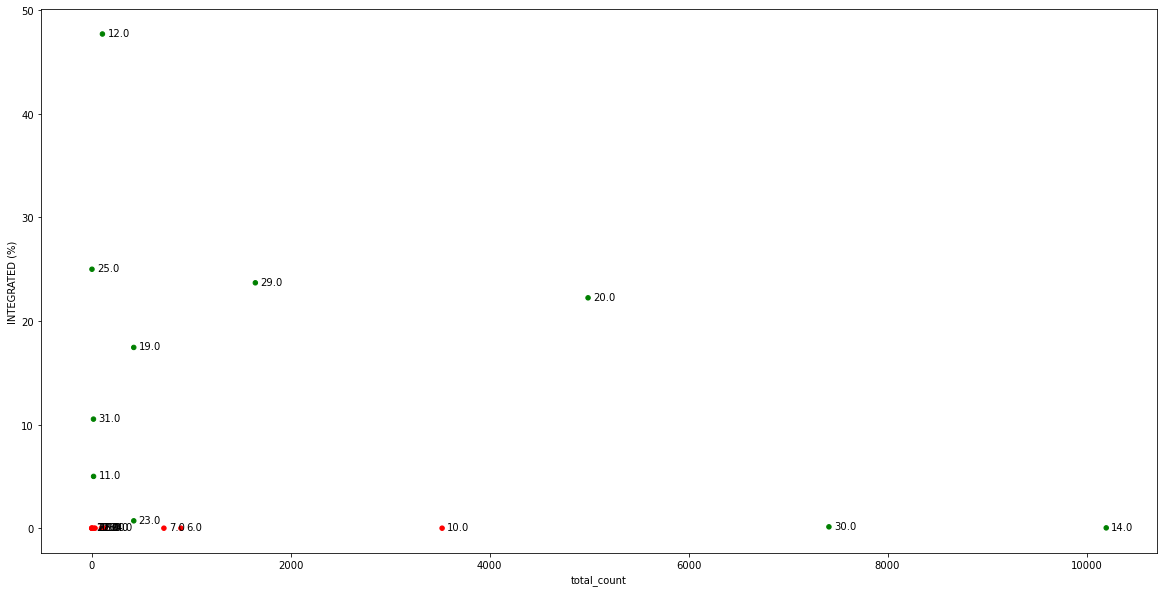

In [15]:
PlotData=transfers_with_sender_and_intermediate_errors_total[['total_count','INTEGRATED (%)']]
PlotData['colour']='green'
PlotData.loc[PlotData['INTEGRATED (%)']==0,'colour']='red'
PlotData.plot.scatter(x='total_count',y='INTEGRATED (%)',c='colour',figsize=(20,10))
LabellingData=PlotData.reset_index()[['total_count','INTEGRATED (%)','index']]
LabellingData['total_count']=LabellingData['total_count']+50
LabellingData['INTEGRATED (%)']=LabellingData['INTEGRATED (%)']-0.2
LabellingData.apply(lambda row: plt.gca().text(*row),axis=1);
